In [22]:
import os
import itk
import itkwidgets
import numpy as np
import matplotlib.pyplot as plt
import parent
import test
from test.test_all import TEST_DATA_DIR
from test.test_all import download_test_data
download_test_data()

In [6]:
#test_volume = itk.imread(os.path.join(TEST_DATA_DIR, "colab_case/image_preprocessed.nii.gz"))
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/9298954_20050422_10384306_left.nii.gz')


test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101107.nii.gz')
# works fine
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103.nii.gz')
#test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101109.nii.gz')
test_volume = itk.imread('/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101114.nii.gz')

In [7]:
itkwidgets.view(test_volume)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [4]:
import oai_analysis_2
obj = oai_analysis_2.AnalysisObject()
FC, TC = obj.segment(test_volume)

Loading parameter file = /home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_train_config.pth.tar
=> loading checkpoint '/home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_model.pth.tar'
=> loaded checkpoint '/home/pranjal.sahu/OAI/OAI_analysis_2/data/segmentation_model.pth.tar' (epoch 600)


In [5]:
itkwidgets.view(FC)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [29]:
# Read the dicom image series

import itk
import glob
import os

dirName = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101101'
#dirName = '/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/9298954_20050422_10384306_left'

def image_normalize(image, window_min_perc, window_max_perc, output_min, output_max):
    window_rescale = itk.IntensityWindowingImageFilter[type(image), type(image)].New()
    image_array = itk.GetArrayFromImage(image)
    
    window_min = np.percentile(image_array, window_min_perc)
    window_max = np.percentile(image_array, window_max_perc)
    
    window_rescale.SetInput(image)
    window_rescale.SetOutputMaximum(output_max)
    window_rescale.SetOutputMinimum(output_min)
    window_rescale.SetWindowMaximum(window_max)
    window_rescale.SetWindowMinimum(window_min)
    window_rescale.Update()
    
    return window_rescale.GetOutput()

def get_normalized_image(dirName):
    PixelType = itk.ctype("signed short")
    Dimension = 3

    ImageType = itk.Image[PixelType, Dimension]

    namesGenerator = itk.GDCMSeriesFileNames.New()
    namesGenerator.SetUseSeriesDetails(True)
    namesGenerator.AddSeriesRestriction("0008|0021")
    namesGenerator.SetGlobalWarningDisplay(False)
    namesGenerator.SetDirectory(dirName)

    seriesUID = namesGenerator.GetSeriesUIDs()
    
    for uid in seriesUID:
        seriesIdentifier = uid
        fileNames = namesGenerator.GetFileNames(seriesIdentifier)

        reader  = itk.ImageSeriesReader[ImageType].New()
        dicomIO = itk.GDCMImageIO.New()
        reader.SetImageIO(dicomIO)
        reader.SetFileNames(fileNames)
        reader.ForceOrthogonalDirectionOff()
        reader.Update()
        image = reader.GetOutput()
        
        metadata = dicomIO.GetMetaDataDictionary()
        #print('key is ', metadata['0008|103e'])
    
        float_filter = itk.CastImageFilter[type(image), itk.Image.F3].New()
        float_filter.SetInput(image)
        float_filter.Update()
        image = float_filter.GetOutput()
        
        img_normalized = image_normalize(image, 0.1, 99.9, 0, 1)
        
        return img_normalized, metadata['0008|103e']
        

#folder_name = '/media/pranjal.sahu/moredata/OAI-MATT/9298954_20050422_10384306_left-20220531T150108Z-001/'
folder_name = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/'

all_names = glob.glob(folder_name+'*')
for name in all_names:
    if os.path.isdir(name):
        normalized_img, metadata = get_normalized_image(name)
        if 'DESS' in metadata:
            new_name =  name + '_' + metadata.split('_')[-1].strip()+'.nii.gz'
            print(new_name, normalized_img.shape, metadata)
            itk.imwrite(normalized_img, new_name)

/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101109_RIGHT.nii.gz (160, 384, 384) SAG_3D_DESS_RIGHT 
/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103_LEFT.nii.gz (160, 384, 384) SAG_3D_DESS_LEFT


In [18]:
dirName = '/media/pranjal.sahu/moredata/OAI-MATT/20051007/10101103/'

PixelType = itk.ctype("signed short")
Dimension = 3
ImageType = itk.Image[PixelType, Dimension]
    
namesGenerator = itk.GDCMSeriesFileNames.New()
namesGenerator.SetUseSeriesDetails(True)
namesGenerator.AddSeriesRestriction("0008|0021")
namesGenerator.SetGlobalWarningDisplay(False)
namesGenerator.SetDirectory(dirName)

seriesUID = namesGenerator.GetSeriesUIDs()

print(seriesUID)

for uid in seriesUID:
    seriesIdentifier = uid
    fileNames = namesGenerator.GetFileNames(seriesIdentifier)

    reader  = itk.ImageSeriesReader[ImageType].New()
    dicomIO = itk.GDCMImageIO.New()
    dicomIO.LoadPrivateTagsOn()
    
    reader.SetImageIO(dicomIO)
    reader.SetFileNames(fileNames)
    reader.ForceOrthogonalDirectionOff()
    reader.Update()
    image = reader.GetOutput()
    
    metadata = dicomIO.GetMetaDataDictionary()
    
    print('key is ', metadata['0008|103e'])

('1.3.12.2.1107.5.2.13.20576.4.0.4671522628072110.3de3d10.6999999938438420051007',)
key is  SAG_3D_DESS_LEFT


In [16]:
tagkeys = metadata.GetKeys()


for k in tagkeys:
    print('k is ', k)
    print(metadata[k])

k is  0008|0000
472
k is  0008|0005
ISO_IR 100
k is  0008|0008
ORIGINAL\PRIMARY\M\DIS2D
k is  0008|0016
1.2.840.10008.5.1.4.1.1.4
k is  0008|0018
1.2.826.0.1.3680043.2.429.0.166101011.1129741841.1.3.1
k is  0008|0020
20051007
k is  0008|0021
20051007
k is  0008|0022
20051007
k is  0008|0023
20051007
k is  0008|0030
144844.718000 
k is  0008|0031
150839.765000 
k is  0008|0032
145522.229992 
k is  0008|0033
150839.781000 
k is  0008|0050
016610101103
k is  0008|0060
MR
k is  0008|0070
SIEMENS 
k is  0008|0080
OAI Image Release 1.C.1 
k is  0008|0090

k is  0008|1010

k is  0008|1030
OAI^MR^12 MONTH^LEFT
k is  0008|103e
SAG_3D_DESS_LEFT
k is  0008|1050

k is  0008|1060

k is  0008|1090
Trio
k is  0010|0000
90
k is  0010|0010
OAI9000296
k is  0010|0020
9000296 
k is  0010|0030

k is  0010|0040
O 
k is  0010|1000
016610101103
k is  0010|1010

k is  0010|4000
12
k is  0012|0050
V01 
k is  0012|0051
12 month Annual Visit 
k is  0018|0000
464
k is  0018|0015
KNEE
k is  0018|0020
SE
k is  0018

RuntimeError: Can't downcast to a specialization of MetaDataObject

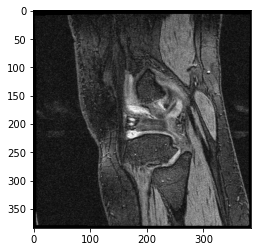

In [46]:
plt.imshow(normalized_img[32], cmap='gray')

In [28]:
itk.imwrite(img_normalized, 'img_normalized.nii.gz')